In [26]:
## Cargando paquetes mejorado
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Cargar los datos

In [27]:
# Descarga y carga de datos
import kagglehub
import os

path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
print("Path to dataset files:", path)

# Verificación de carga
print("\nArchivos en el directorio:", os.listdir(path))

# Carga con verificación de tipos de datos
dtype_dict = {
    'Age': 'int64',
    'Sex': 'category',
    'ChestPainType': 'category',
    'RestingBP': 'int64',
    'Cholesterol': 'int64',
    'FastingBS': 'int64',
    'RestingECG': 'category',
    'MaxHR': 'int64',
    'ExerciseAngina': 'category',
    'Oldpeak': 'float64',
    'ST_Slope': 'category',
    'HeartDisease': 'int64'
}

df = pd.read_csv(os.path.join(path, "heart.csv"), dtype=dtype_dict)

# Verificación inicial
print("\nDataset cargado - Dimensiones:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
print("\nPrimeras filas:")
display(df.head())


Path to dataset files: /kaggle/input/heart-failure-prediction

Archivos en el directorio: ['heart.csv']

Dataset cargado - Dimensiones: (918, 12)

Tipos de datos:
 Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS            int64
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object

Primeras filas:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Análisis Exploratorio Mejorado (EDA)


Estadísticas descriptivas:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,nan,2,4,nan,nan,nan,3,nan,2,nan,3,nan
top,nan,M,ASY,nan,nan,nan,Normal,nan,N,nan,Flat,nan
freq,nan,725,496,nan,nan,nan,552,nan,547,nan,460,nan
mean,53.510893,nan,nan,132.396514,198.799564,0.233115,nan,136.809368,nan,0.887364,nan,0.553377
std,9.432617,nan,nan,18.514154,109.384145,0.423046,nan,25.460334,nan,1.066570,nan,0.497414
min,28.000000,nan,nan,0.000000,0.000000,0.000000,nan,60.000000,nan,-2.600000,nan,0.000000
25%,47.000000,nan,nan,120.000000,173.250000,0.000000,nan,120.000000,nan,0.000000,nan,0.000000
50%,54.000000,nan,nan,130.000000,223.000000,0.000000,nan,138.000000,nan,0.600000,nan,1.000000
75%,60.000000,nan,nan,140.000000,267.000000,0.000000,nan,156.000000,nan,1.500000,nan,1.000000



Valores faltantes por columna:


,Valores Faltantes,Porcentaje
Age,0,0.000000
Sex,0,0.000000
ChestPainType,0,0.000000
RestingBP,0,0.000000
Cholesterol,0,0.000000
FastingBS,0,0.000000
RestingECG,0,0.000000
MaxHR,0,0.000000
ExerciseAngina,0,0.000000
Oldpeak,0,0.000000


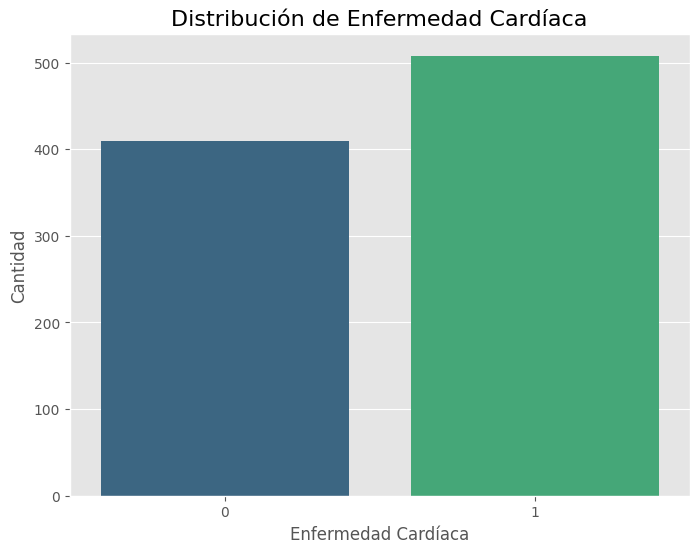

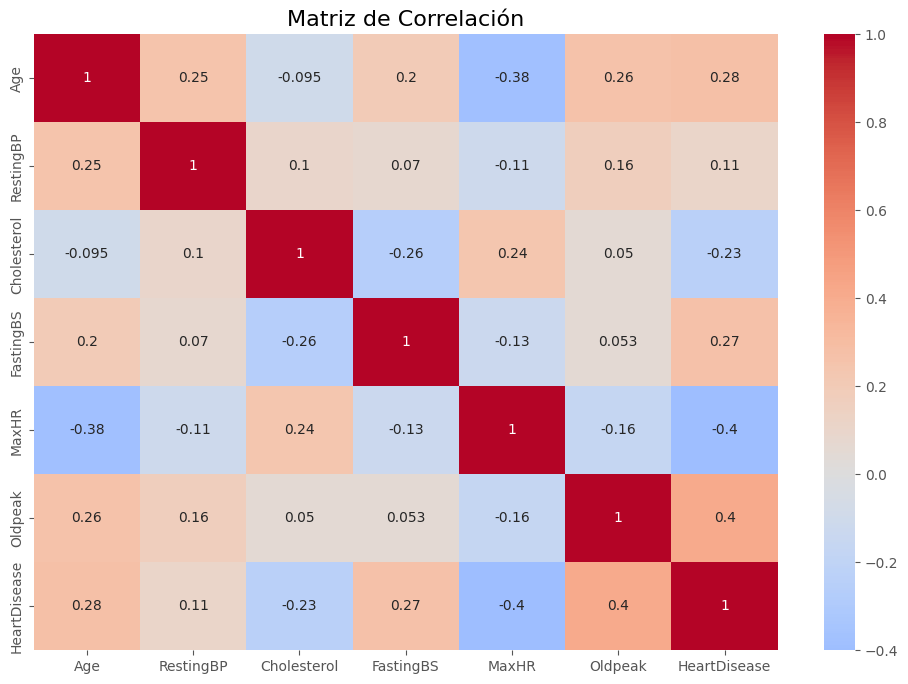

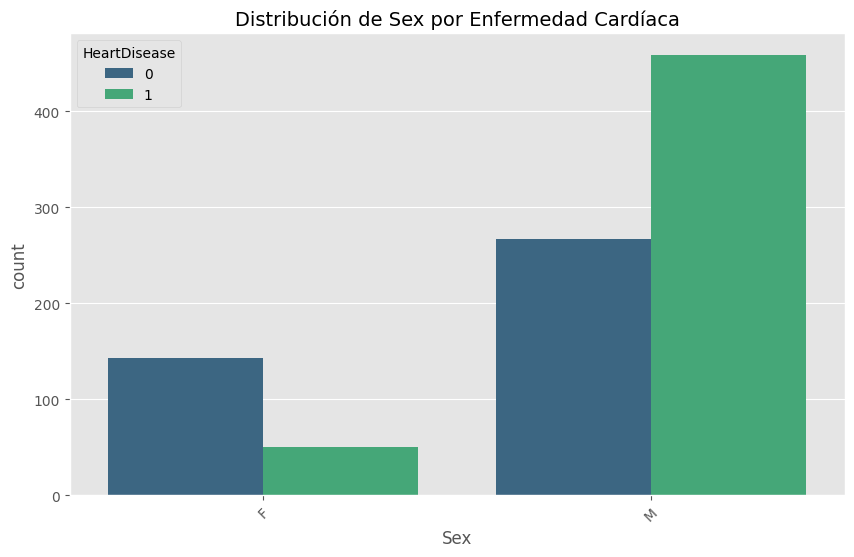

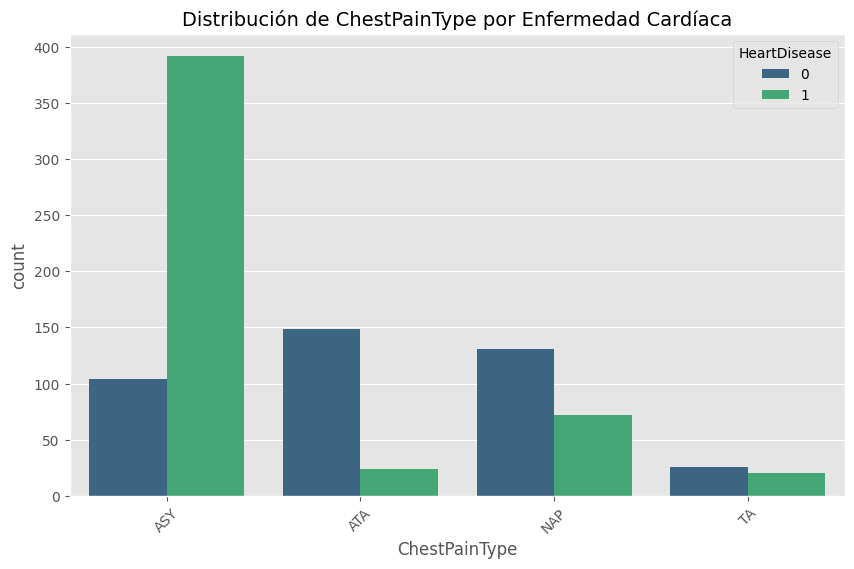

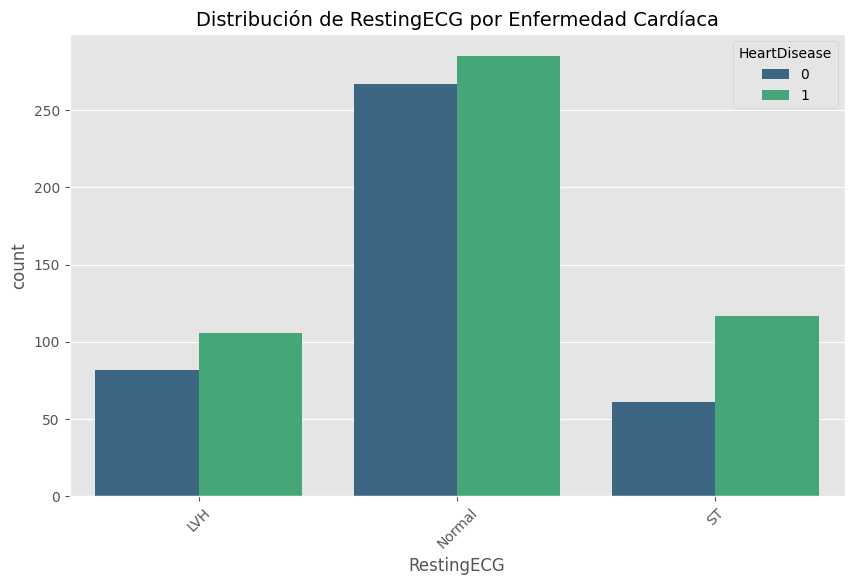

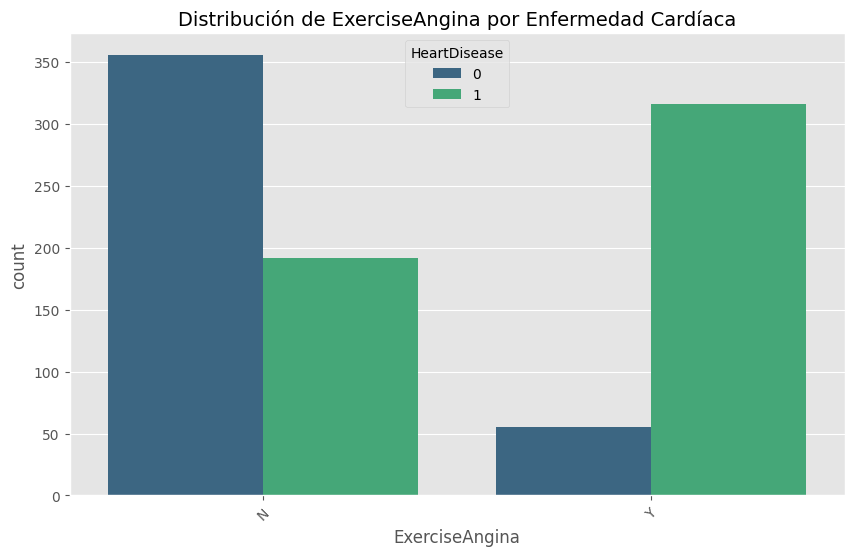

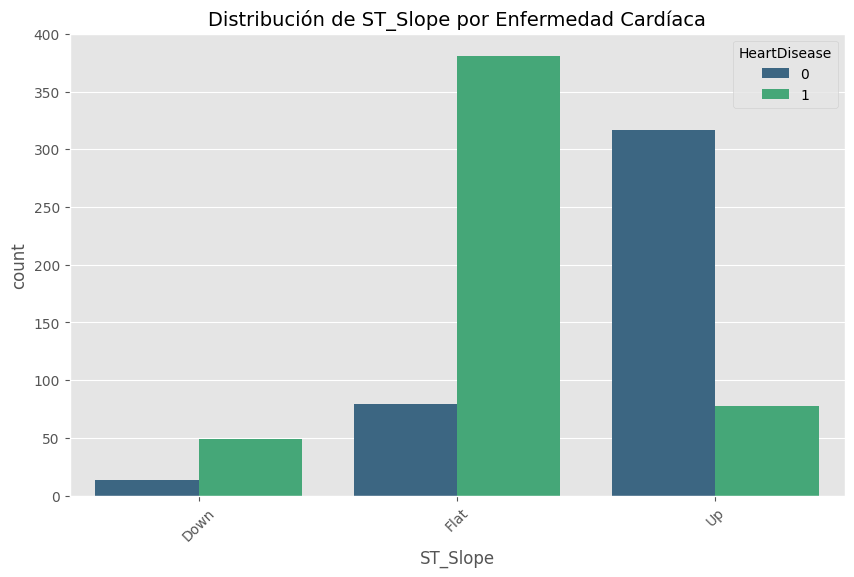

In [29]:
# Análisis estadístico completo
print("\nEstadísticas descriptivas:")
display(df.describe(include='all').style.background_gradient(cmap='coolwarm'))

# Análisis de valores nulos mejorado
print("\nValores faltantes por columna:")
missing_data = df.isna().sum().to_frame(name='Valores Faltantes')
missing_data['Porcentaje'] = (missing_data['Valores Faltantes'] / len(df)) * 100
display(missing_data.style.background_gradient(cmap='Reds'))

# Análisis de balance de clases
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='HeartDisease', palette='viridis')
plt.title('Distribución de Enfermedad Cardíaca', fontsize=16)
plt.xlabel('Enfermedad Cardíaca', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.show()

# Análisis de correlaciones numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

# Análisis de variables categóricas
categorical_cols = df.select_dtypes(include=['category']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='HeartDisease', palette='viridis')
    plt.title(f'Distribución de {col} por Enfermedad Cardíaca', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Preprocesamiento Robusto

In [30]:
# 1. Manejo de outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Aplicar a columnas numéricas
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in numeric_cols:
    df = handle_outliers(df, col)

# 2. Transformación de variables
# Convertir variables binarias a 0/1
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})
df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})

# 3. Definir pipeline de preprocesamiento
# Columnas para diferentes transformaciones
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['ChestPainType', 'RestingECG', 'ST_Slope']
binary_features = ['Sex', 'ExerciseAngina', 'FastingBS']

# Transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Preprocesador completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features)])

# 4. Separar características y objetivo
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# 5. División train-test (estratificada)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar preprocesamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Obtener nombres de características después de one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_features, binary_features])

print("\nPreprocesamiento completado con éxito!")
print(f"\nDimensiones después de preprocesamiento:")
print(f"Entrenamiento: {X_train_preprocessed.shape}")
print(f"Prueba: {X_test_preprocessed.shape}")


Preprocesamiento completado con éxito!

Dimensiones después de preprocesamiento:
Entrenamiento: (734, 18)
Prueba: (184, 18)


# Modelado y Evaluación

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Puntajes F1 en validación cruzada (Regresión Logística): [0.90797546 0.87341772 0.85534591 0.8427673  0.81927711]
F1 promedio: 0.860 ± 0.030

Comparativa de Modelos:


,accuracy,precision,recall,f1,auc,average_precision
model,,,,,,
Random Forest,0.842391,0.861386,0.852941,0.857143,0.909672,0.920414
XGBoost,0.847826,0.870000,0.852941,0.861386,0.912004,0.925239
Random Forest (Optimizado),0.853261,0.850467,0.892157,0.870813,0.921449,0.928848
Regresión Logística,0.869565,0.897959,0.862745,0.880000,0.932807,0.940967


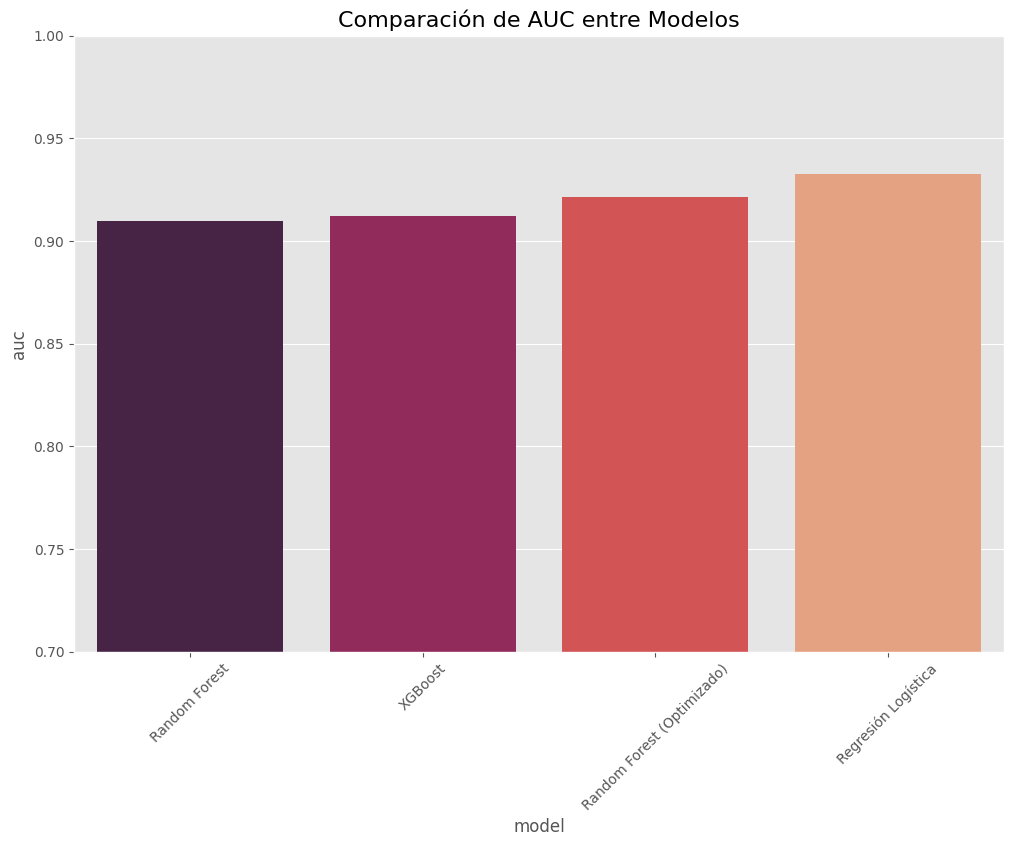

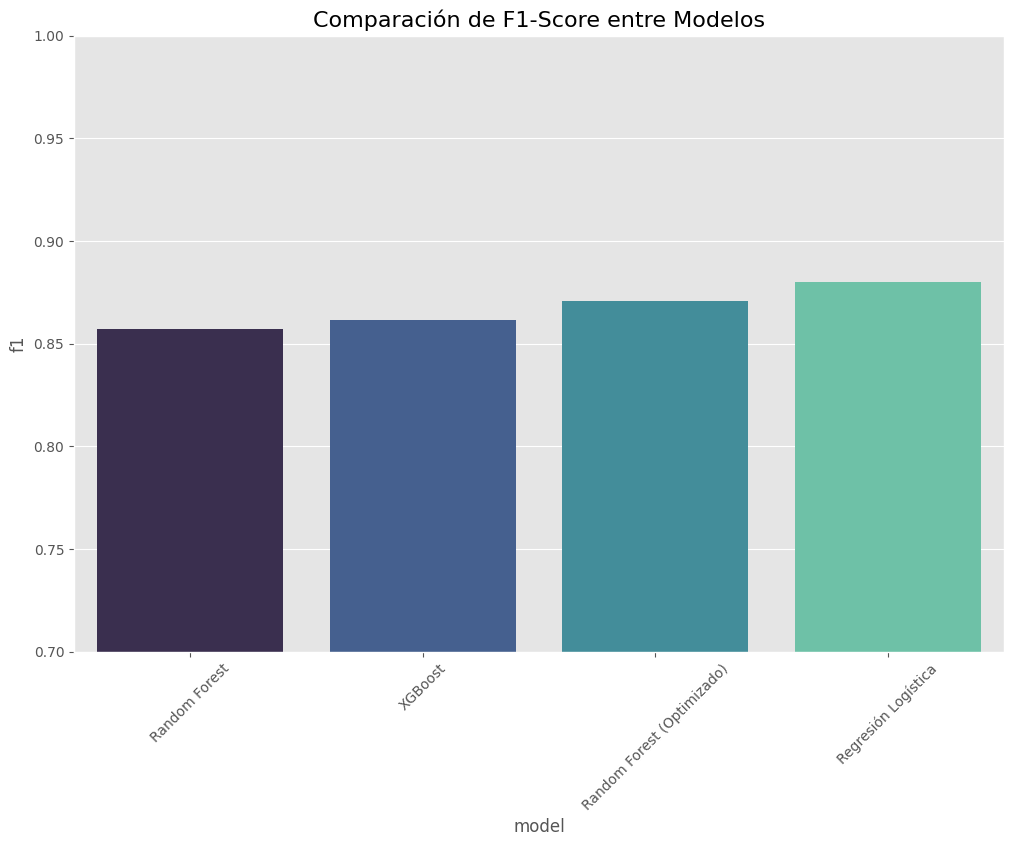

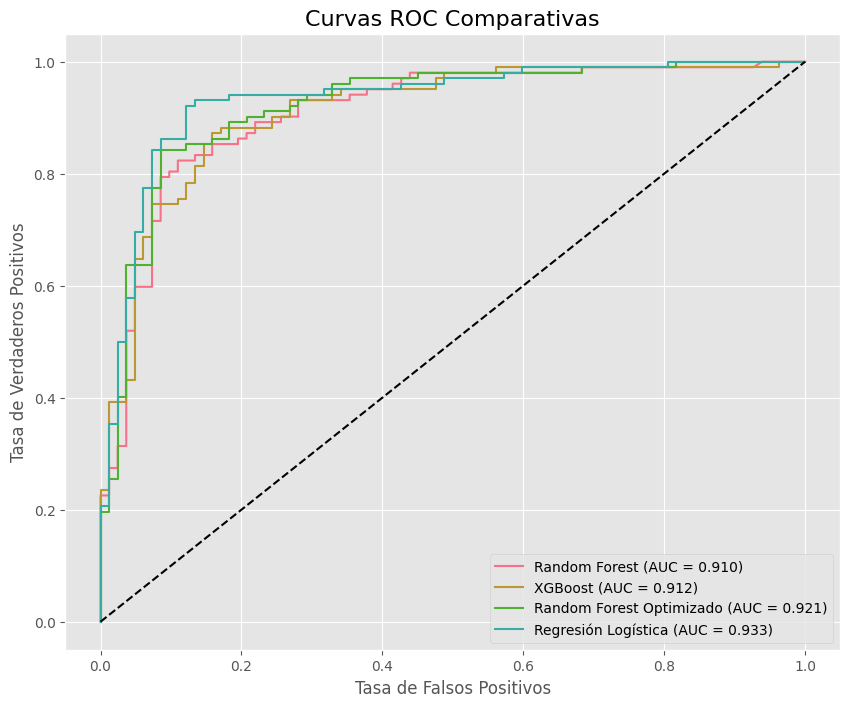

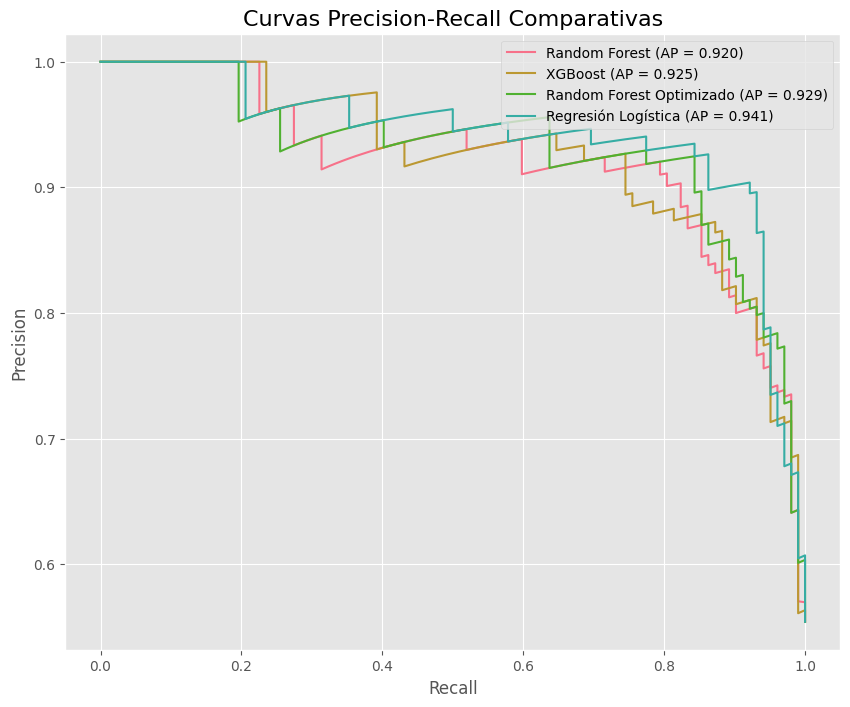

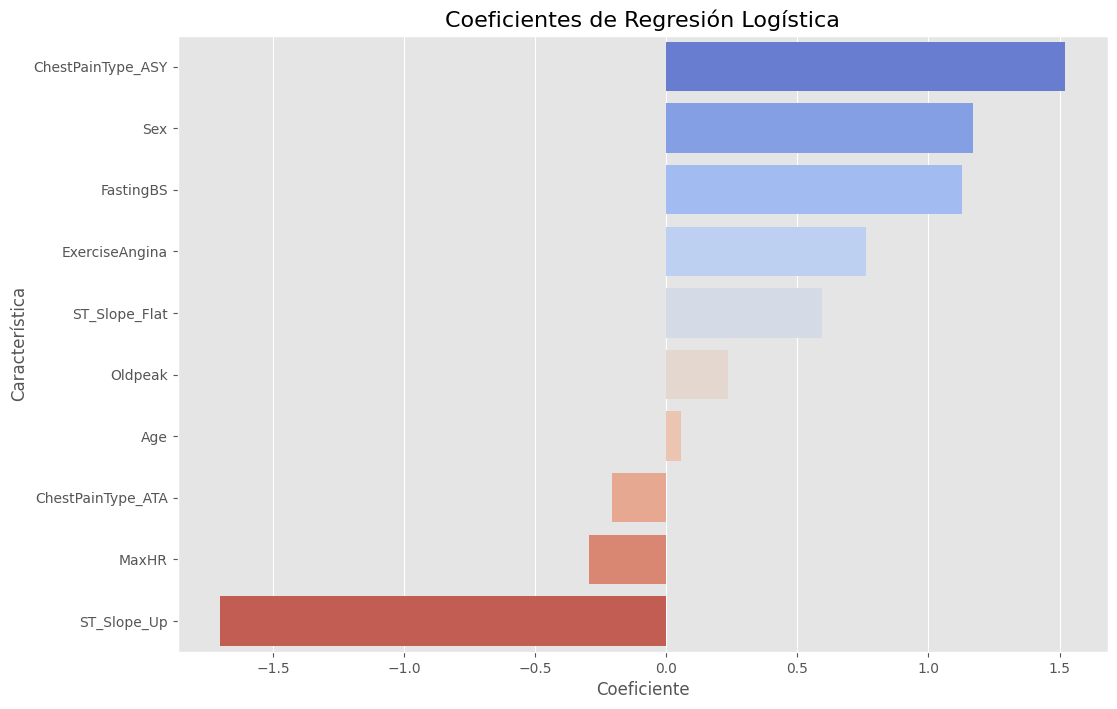

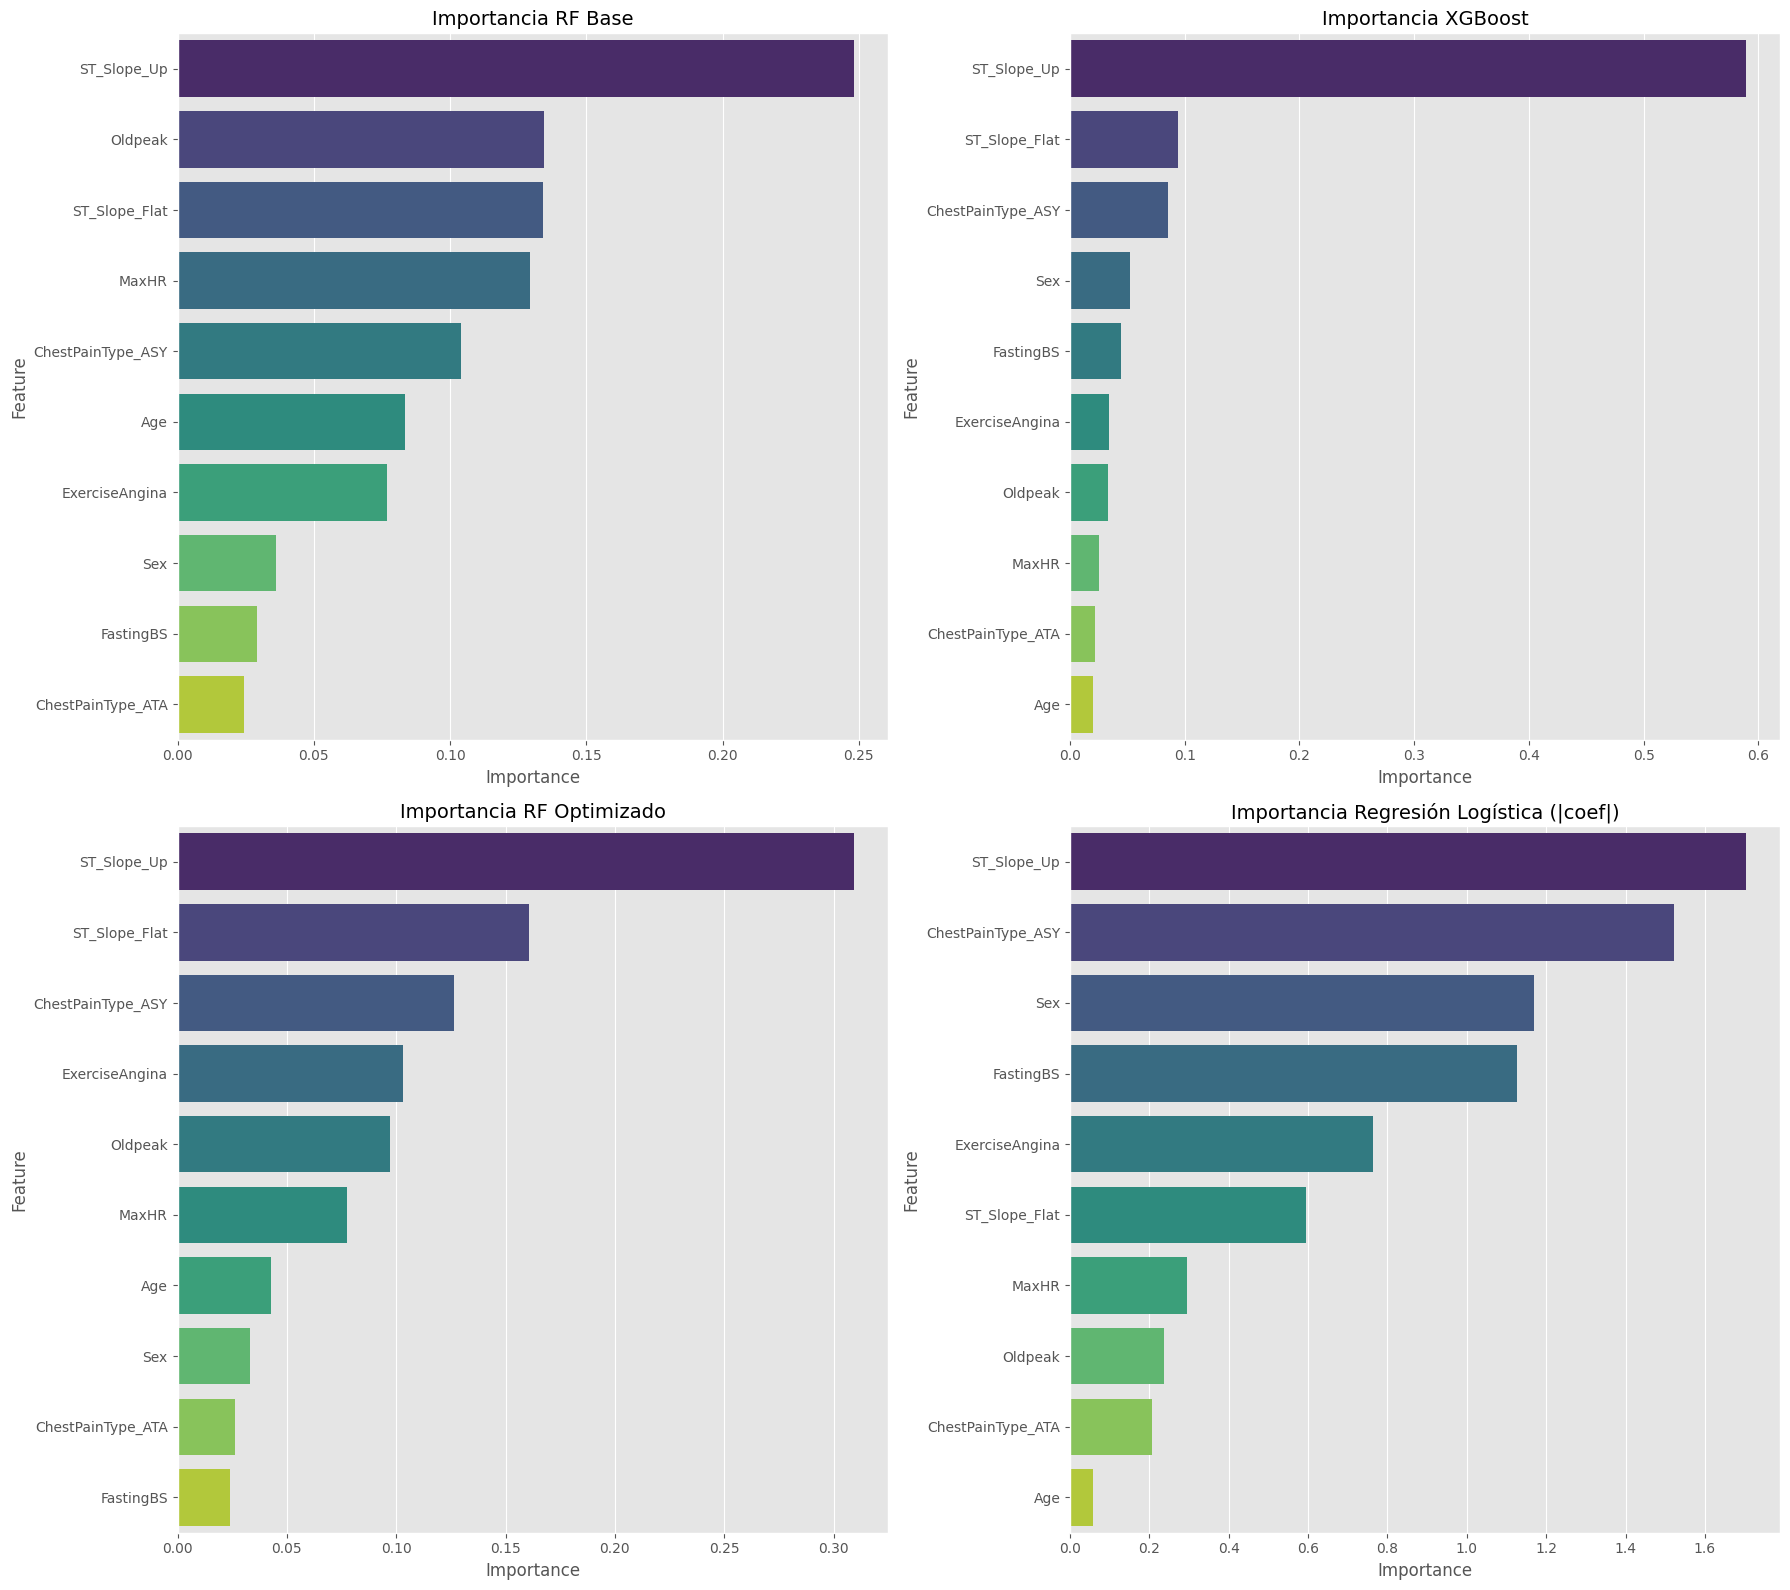

In [33]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

## Configuración inicial
# Para mejor reproducibilidad
np.random.seed(42)

# Lista para almacenar resultados
model_results = []

## 1. Random Forest (como línea base)
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced')

rf_model.fit(X_train_selected, y_train)
y_pred_rf = rf_model.predict(X_test_selected)
y_proba_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Métricas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
auc_rf = roc_auc_score(y_test, y_proba_rf)
ap_rf = average_precision_score(y_test, y_proba_rf)

model_results.append({
    'model': 'Random Forest',
    'accuracy': accuracy_rf,
    'precision': report_rf['1']['precision'],
    'recall': report_rf['1']['recall'],
    'f1': report_rf['1']['f1-score'],
    'auc': auc_rf,
    'average_precision': ap_rf
})

## 2. XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])  # Balanceo de clases
)

xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)
y_proba_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

# Métricas
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
ap_xgb = average_precision_score(y_test, y_proba_xgb)

model_results.append({
    'model': 'XGBoost',
    'accuracy': accuracy_xgb,
    'precision': report_xgb['1']['precision'],
    'recall': report_xgb['1']['recall'],
    'f1': report_xgb['1']['f1-score'],
    'auc': auc_xgb,
    'average_precision': ap_xgb
})

## 3. Random Forest con GridSearch (optimizado)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 8, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1)

rf_grid.fit(X_train_selected, y_train)

# Mejor modelo
best_rf = rf_grid.best_estimator_
y_pred_rf_grid = best_rf.predict(X_test_selected)
y_proba_rf_grid = best_rf.predict_proba(X_test_selected)[:, 1]

# Métricas
accuracy_rf_grid = accuracy_score(y_test, y_pred_rf_grid)
report_rf_grid = classification_report(y_test, y_pred_rf_grid, output_dict=True)
auc_rf_grid = roc_auc_score(y_test, y_proba_rf_grid)
ap_rf_grid = average_precision_score(y_test, y_proba_rf_grid)

model_results.append({
    'model': 'Random Forest (Optimizado)',
    'accuracy': accuracy_rf_grid,
    'precision': report_rf_grid['1']['precision'],
    'recall': report_rf_grid['1']['recall'],
    'f1': report_rf_grid['1']['f1-score'],
    'auc': auc_rf_grid,
    'average_precision': ap_rf_grid
})

## 4. Regresión Logística
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=42,
    class_weight='balanced',
    max_iter=1000)

# Validación cruzada para evaluar robustez
cv_scores = cross_val_score(lr_model, X_train_selected, y_train, cv=5, scoring='f1')
print(f"\nPuntajes F1 en validación cruzada (Regresión Logística): {cv_scores}")
print(f"F1 promedio: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# Entrenamiento final
lr_model.fit(X_train_selected, y_train)
y_pred_lr = lr_model.predict(X_test_selected)
y_proba_lr = lr_model.predict_proba(X_test_selected)[:, 1]

# Métricas
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
auc_lr = roc_auc_score(y_test, y_proba_lr)
ap_lr = average_precision_score(y_test, y_proba_lr)

model_results.append({
    'model': 'Regresión Logística',
    'accuracy': accuracy_lr,
    'precision': report_lr['1']['precision'],
    'recall': report_lr['1']['recall'],
    'f1': report_lr['1']['f1-score'],
    'auc': auc_lr,
    'average_precision': ap_lr
})

## Comparativa de Modelos
results_df = pd.DataFrame(model_results).set_index('model')
print("\nComparativa de Modelos:")
display(results_df.style.background_gradient(cmap='viridis', subset=['accuracy', 'auc', 'f1']))

## Visualización Comparativa
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df.reset_index(), x='model', y='auc', palette='rocket')
plt.title('Comparación de AUC entre Modelos', fontsize=16)
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=results_df.reset_index(), x='model', y='f1', palette='mako')
plt.title('Comparación de F1-Score entre Modelos', fontsize=16)
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.show()

## Curvas ROC Comparativas
plt.figure(figsize=(10, 8))

# Calcular y graficar curvas ROC para cada modelo
models = {
    'Random Forest': y_proba_rf,
    'XGBoost': y_proba_xgb,
    'Random Forest Optimizado': y_proba_rf_grid,
    'Regresión Logística': y_proba_lr
}

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC Comparativas', fontsize=16)
plt.legend(loc='lower right')
plt.show()

## Curvas Precision-Recall Comparativas
plt.figure(figsize=(10, 8))

for name, probs in models.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap_score = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f'{name} (AP = {ap_score:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curvas Precision-Recall Comparativas', fontsize=16)
plt.legend(loc='upper right')
plt.show()

## Interpretación de Modelos (Coeficientes LR y Feature Importance)
# Coeficientes de Regresión Logística
lr_coef = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=lr_coef, palette='coolwarm')
plt.title('Coeficientes de Regresión Logística', fontsize=16)
plt.xlabel('Coeficiente', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.show()

# Feature Importance comparativa
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Random Forest
rf_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(ax=axes[0, 0], x='Importance', y='Feature', data=rf_importance, palette='viridis')
axes[0, 0].set_title('Importancia RF Base', fontsize=14)

# XGBoost
xgb_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(ax=axes[0, 1], x='Importance', y='Feature', data=xgb_importance, palette='viridis')
axes[0, 1].set_title('Importancia XGBoost', fontsize=14)

# Random Forest Optimizado
rf_grid_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(ax=axes[1, 0], x='Importance', y='Feature', data=rf_grid_importance, palette='viridis')
axes[1, 0].set_title('Importancia RF Optimizado', fontsize=14)

# Regresión Logística (valor absoluto de coeficientes)
lr_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': np.abs(lr_model.coef_[0])
}).sort_values('Importance', ascending=False)
sns.barplot(ax=axes[1, 1], x='Importance', y='Feature', data=lr_importance, palette='viridis')
axes[1, 1].set_title('Importancia Regresión Logística (|coef|)', fontsize=14)

plt.tight_layout()
plt.show()


Comparativa de Modelos (incluyendo CatBoost):


,accuracy,precision,recall,f1,auc,average_precision
model,,,,,,
Random Forest,0.842391,0.861386,0.852941,0.857143,0.909672,0.920414
XGBoost,0.847826,0.870000,0.852941,0.861386,0.912004,0.925239
Random Forest (Optimizado),0.853261,0.850467,0.892157,0.870813,0.921449,0.928848
Regresión Logística,0.869565,0.897959,0.862745,0.880000,0.932807,0.940967
CatBoost,0.858696,0.887755,0.852941,0.870000,0.927308,0.939343


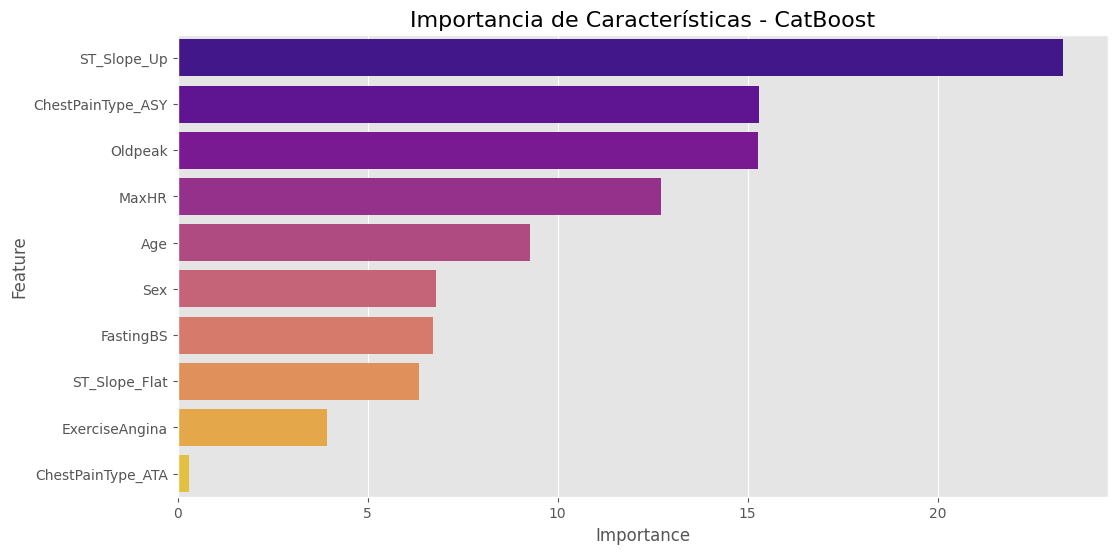

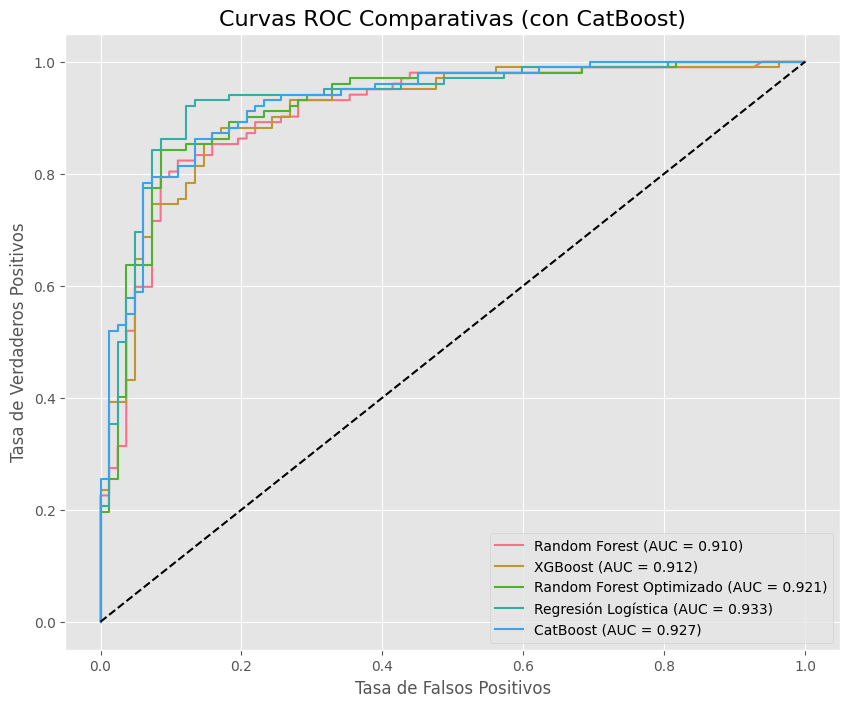

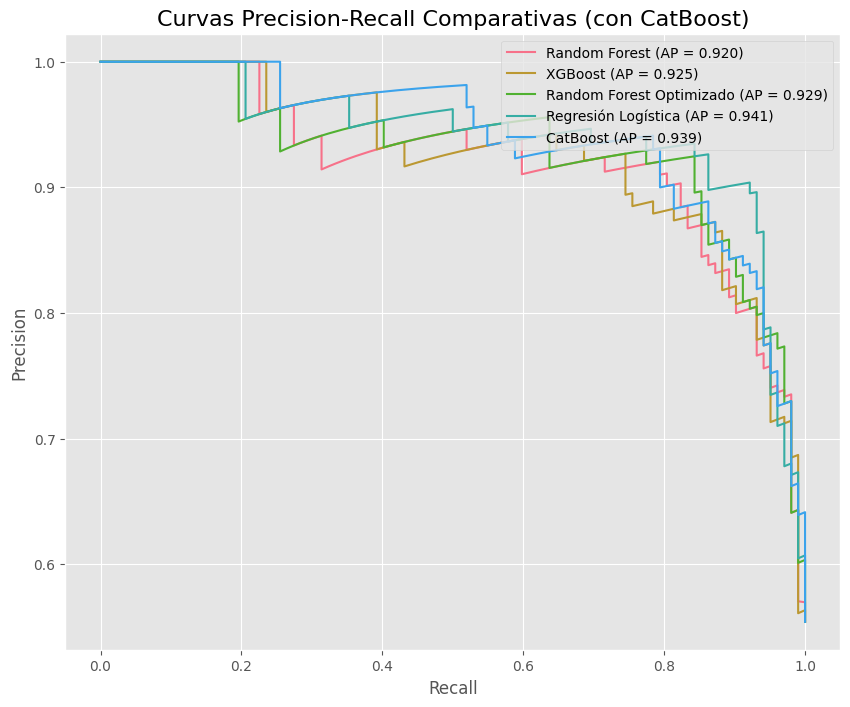

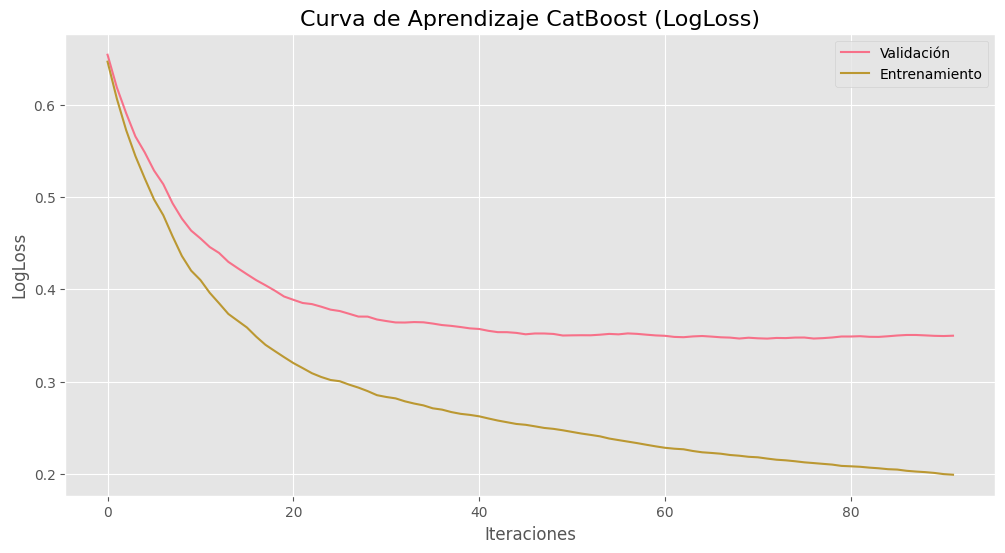

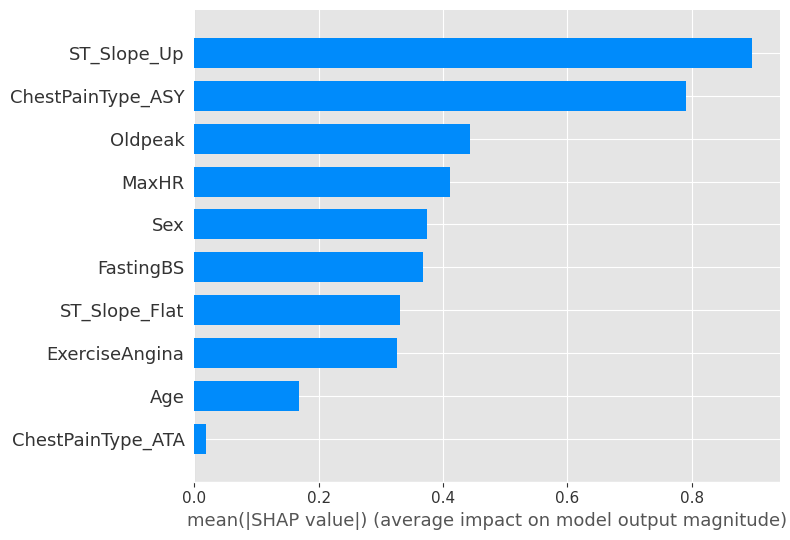

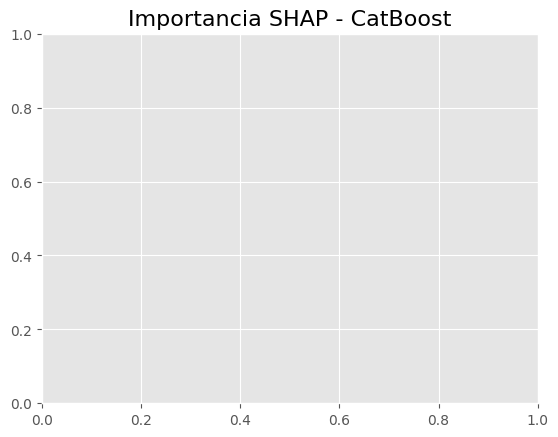

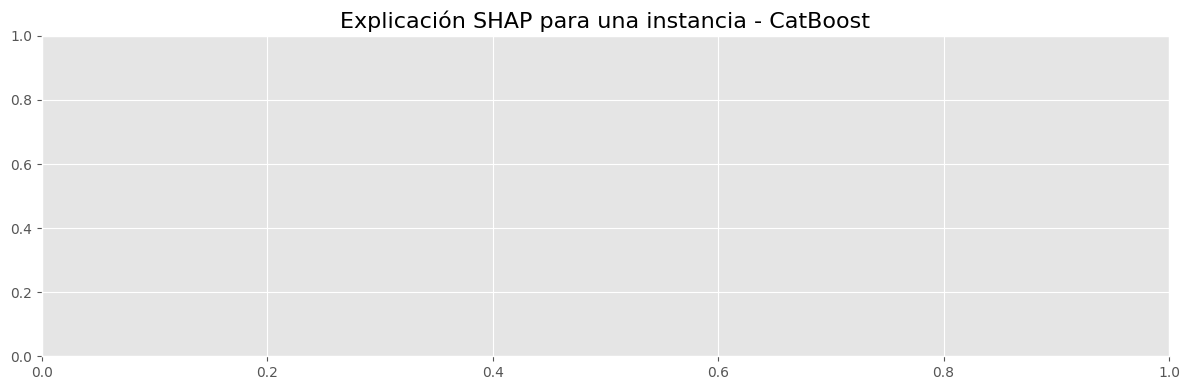

In [34]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve

## 5. CatBoost Classifier
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    border_count=32,
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=0,  # Silenciar output durante entrenamiento
    early_stopping_rounds=20
)

# Entrenamiento con early stopping
cat_model.fit(
    X_train_selected, y_train,
    eval_set=(X_test_selected, y_test),
    use_best_model=True
)

# Predicciones
y_pred_cat = cat_model.predict(X_test_selected)
y_proba_cat = cat_model.predict_proba(X_test_selected)[:, 1]

# Métricas
accuracy_cat = accuracy_score(y_test, y_pred_cat)
report_cat = classification_report(y_test, y_pred_cat, output_dict=True)
auc_cat = roc_auc_score(y_test, y_proba_cat)
ap_cat = average_precision_score(y_test, y_proba_cat)

# Agregar a resultados
model_results.append({
    'model': 'CatBoost',
    'accuracy': accuracy_cat,
    'precision': report_cat['1']['precision'],
    'recall': report_cat['1']['recall'],
    'f1': report_cat['1']['f1-score'],
    'auc': auc_cat,
    'average_precision': ap_cat
})

## Actualización de la comparativa de modelos
results_df = pd.DataFrame(model_results).set_index('model')
print("\nComparativa de Modelos (incluyendo CatBoost):")
display(results_df.style.background_gradient(cmap='viridis', subset=['accuracy', 'auc', 'f1']))

## Visualización adicional específica para CatBoost
plt.figure(figsize=(12, 6))

# Importancia de características
cat_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': cat_model.get_feature_importance()
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=cat_importance, palette='plasma')
plt.title('Importancia de Características - CatBoost', fontsize=16)
plt.show()

## Curvas ROC actualizadas con CatBoost
plt.figure(figsize=(10, 8))

# Actualizar diccionario de modelos
models['CatBoost'] = y_proba_cat

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC Comparativas (con CatBoost)', fontsize=16)
plt.legend(loc='lower right')
plt.show()

## Curvas Precision-Recall actualizadas
plt.figure(figsize=(10, 8))

for name, probs in models.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap_score = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f'{name} (AP = {ap_score:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curvas Precision-Recall Comparativas (con CatBoost)', fontsize=16)
plt.legend(loc='upper right')
plt.show()

## Análisis de aprendizaje de CatBoost
plt.figure(figsize=(12, 6))

# Obtener métricas de evaluación durante el entrenamiento
eval_metrics = cat_model.evals_result_

plt.plot(eval_metrics['validation']['Logloss'], label='Validación')
plt.plot(eval_metrics['learn']['Logloss'], label='Entrenamiento')
plt.title('Curva de Aprendizaje CatBoost (LogLoss)', fontsize=16)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('LogLoss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Interpretación SHAP para CatBoost (Opcional pero recomendado)
try:
    import shap

    # Crear explainer
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(X_test_selected)

    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, plot_type="bar")
    plt.title('Importancia SHAP - CatBoost', fontsize=16)
    plt.show()

    # Force plot para una observación específica (ejemplo: primera observación)
    plt.figure(figsize=(12, 4))
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_selected[0,:], feature_names=selected_features)
    plt.title('Explicación SHAP para una instancia - CatBoost', fontsize=16)
    plt.tight_layout()
    plt.show()

except ImportError:
    print("\nPara visualizaciones SHAP, instala el paquete: pip install shap")

# Selección Automática del Mejor Modelo

Voy a proporcionarte un código completo para seleccionar automáticamente el mejor modelo basado en tus métricas de evaluación, incluyendo una validación robusta y la capacidad de guardar el modelo ganador.

In [35]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score

## 1. Definir función para evaluar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Entrenamiento
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Métricas
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'avg_precision': average_precision_score(y_test, y_proba)
    }

    # Validación cruzada (F1 score)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    metrics['cv_f1_mean'] = np.mean(cv_scores)
    metrics['cv_f1_std'] = np.std(cv_scores)

    return model, metrics

## 2. Definir todos los modelos a comparar
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])
    ),
    'CatBoost': CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        random_seed=42,
        auto_class_weights='Balanced',
        verbose=0,
        early_stopping_rounds=20
    ),
    'LogisticRegression': LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    )
}

## 3. Evaluar todos los modelos
results = []
best_model = None
best_score = -np.inf

for name, model in models.items():
    print(f"\nEvaluando modelo: {name}")
    trained_model, metrics = evaluate_model(
        model,
        X_train_selected, y_train,
        X_test_selected, y_test,
        name
    )

    results.append(metrics)

    # Seleccionar el mejor modelo basado en F1 score (puedes cambiar la métrica)
    if metrics['f1'] > best_score:
        best_score = metrics['f1']
        best_model = trained_model
        best_model_name = name

## 4. Mostrar resultados comparativos
results_df = pd.DataFrame(results)
print("\nResultados comparativos de todos los modelos:")
display(results_df.sort_values('f1', ascending=False).style.background_gradient(
    cmap='viridis',
    subset=['accuracy', 'f1', 'roc_auc', 'avg_precision']
))

## 5. Mostrar el mejor modelo seleccionado
print(f"\n🔍 Mejor modelo seleccionado: {best_model_name} con F1-score: {best_score:.4f}")

## 6. Guardar el mejor modelo y el preprocesador
best_model_components = {
    'preprocessor': preprocessor,
    'selector': selector,
    'model': best_model,
    'feature_names': selected_features,
    'metrics': results_df.set_index('model').loc[best_model_name].to_dict()
}

joblib.dump(best_model_components, 'best_heart_disease_model.pkl')
print(f"\n✅ Mejor modelo guardado como: best_heart_disease_model.pkl")

## 7. Función para cargar y usar el modelo guardado
def load_and_predict(new_data):
    """
    Función para cargar el modelo guardado y hacer predicciones en nuevos datos
    """
    # Cargar componentes
    components = joblib.load('best_heart_disease_model.pkl')

    # Preprocesar nuevos datos
    new_data_processed = components['preprocessor'].transform(new_data)
    new_data_selected = components['selector'].transform(new_data_processed)

    # Hacer predicciones
    predictions = components['model'].predict(new_data_selected)
    probabilities = components['model'].predict_proba(new_data_selected)[:, 1]

    return predictions, probabilities

## 8. Ejemplo de uso con los datos de prueba
sample_data = X_test.iloc[:5]  # Tomamos 5 muestras de prueba
predictions, probabilities = load_and_predict(sample_data)

print("\nEjemplo de predicción para 5 casos de prueba:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Caso {i+1}: Predicción = {pred} (Probabilidad: {prob:.2f})")


Evaluando modelo: RandomForest

Evaluando modelo: XGBoost

Evaluando modelo: CatBoost

Evaluando modelo: LogisticRegression

Resultados comparativos de todos los modelos:


,model,accuracy,f1,roc_auc,avg_precision,cv_f1_mean,cv_f1_std
3,LogisticRegression,0.869565,0.880000,0.932807,0.940967,0.859757,0.029861
1,XGBoost,0.847826,0.861386,0.912004,0.925239,0.856148,0.018248
2,CatBoost,0.847826,0.861386,0.920373,0.935728,0.863462,0.015130
0,RandomForest,0.842391,0.857143,0.909672,0.920414,0.867861,0.021667



🔍 Mejor modelo seleccionado: LogisticRegression con F1-score: 0.8800

✅ Mejor modelo guardado como: best_heart_disease_model.pkl

Ejemplo de predicción para 5 casos de prueba:
Caso 1: Predicción = 1 (Probabilidad: 0.94)
Caso 2: Predicción = 0 (Probabilidad: 0.11)
Caso 3: Predicción = 1 (Probabilidad: 0.94)
Caso 4: Predicción = 1 (Probabilidad: 0.56)
Caso 5: Predicción = 0 (Probabilidad: 0.17)


# Cómo modificar la métrica de selección:

Si prefieres seleccionar el mejor modelo basado en otra métrica, solo cambia estas líneas:

In [36]:
# Cambiar 'f1' por 'accuracy', 'roc_auc' o 'avg_precision'
best_metric = 'roc_auc'  # ← Cambia esta variable

# Y actualiza estas líneas en el bucle:
if metrics[best_metric] > best_score:
    best_score = metrics[best_metric]

# Visualización Adicional
Puedes agregar este código para una visualización más completa:

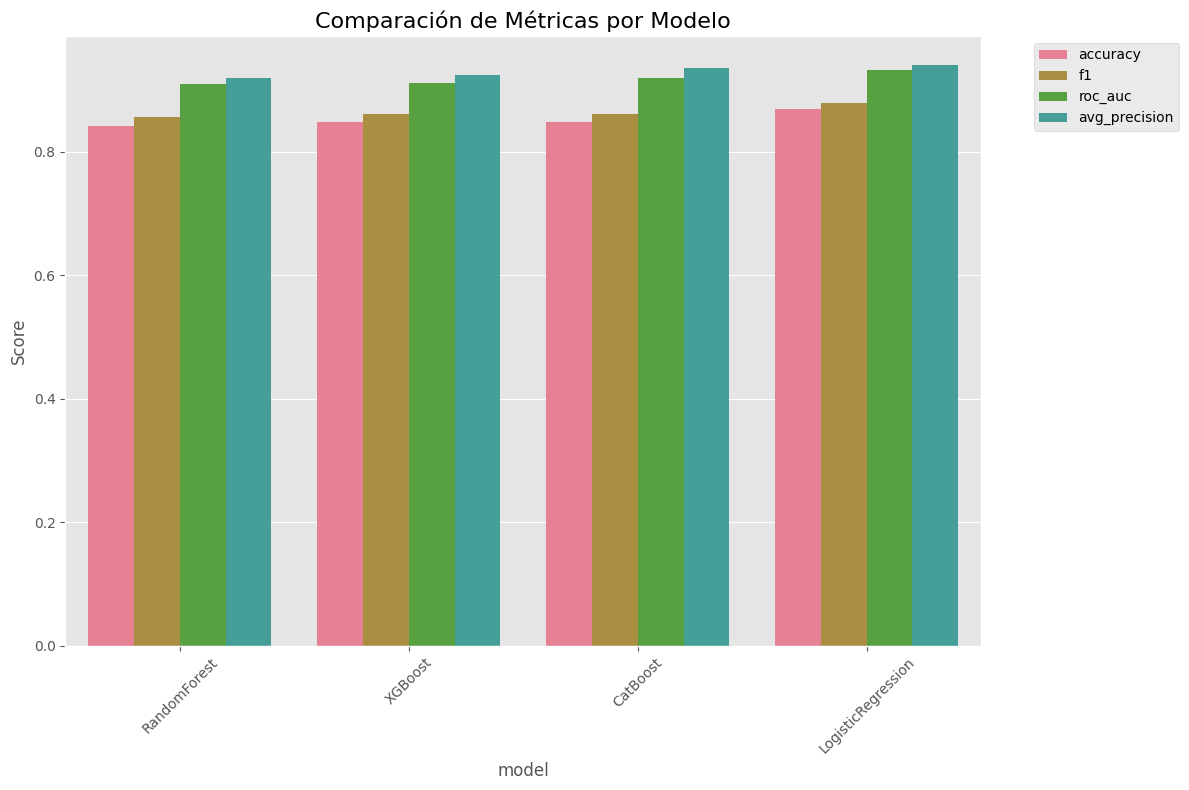

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
metrics_to_plot = ['accuracy', 'f1', 'roc_auc', 'avg_precision']
melted_df = pd.melt(results_df, id_vars=['model'], value_vars=metrics_to_plot)

sns.barplot(data=melted_df, x='model', y='value', hue='variable')
plt.title('Comparación de Métricas por Modelo', fontsize=16)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()